# Wings!

There was this picture of wing prices in Las Vegas circulating around twitter:

![Wing Prices](WingPrices.jfif)

The prices don't really seem to follow an obvious trend and the prices are all over the place.
A user responded to this tweet and posed a good question:

> What is the best combination of wings if you want N wings?

This is a pretty interesting optimization problem as the data doesn't immediately support a solution.
In this article the goal is to walk through ways of approaching this problem and learning about the deeper underlying problem.

## Data Analysis
Before we even get to breaking apart the problem let's just start by getting a better visual interpretation of the scenario.

In [1]:
# Some libs to help us
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Getting the data into a table for easier manipulation
wing_data = {
    "amount": [i for i in range(4, 31)]
    + [35, 40, 45, 50, 60, 70, 75, 80, 90, 100, 125, 150, 200],
    "price": [
        4.55,
        5.7,
        6.8,
        7.95,
        9.1,
        10.2,
        11.35,
        12.5,
        13.6,
        14.75,
        15.9,
        17,
        18.15,
        19.3,
        20.4,
        21.55,
        22.7,
        23.8,
        24.95,
        26.1,
        27.25,
        27.8,
        29.95,
        30.1,
        31.2,
        32.35,
        33.5,
        39.15,
        44.8,
        50.5,
        55.6,
        67,
        78.3,
        83.45,
        89.1,
        100.45,
        111.25,
        139,
        166.85,
        222.5,
    ],
}

wing_df = pd.DataFrame(data=wing_data)

wing_df["price_per_wing"] =  wing_df.price / wing_df.amount

In [3]:
wing_df.head()

,amount,price,price_per_wing
0,4,4.55,1.137500
1,5,5.70,1.140000
2,6,6.80,1.133333
3,7,7.95,1.135714
4,8,9.10,1.137500


In [4]:
wing_df.describe()

,amount,price,price_per_wing
count,40.000000,40.000000,40.000000
mean,39.475000,44.161250,1.126517
std,42.730514,47.457324,0.010983
min,4.000000,4.550000,1.112000
25%,13.750000,15.612500,1.115342
50%,23.500000,26.675000,1.133333
75%,46.250000,51.775000,1.135000
max,200.000000,222.500000,1.151923


Below we are simply plotting the price of the amount of wings you get.
Great news, the data is monotonically increasing, which means it always increases or stays the same given a larger input value.

$$
\text{Given a monotonically increasing function } f: \real \to \real \\
\text{For all } x,y \in \real \text{ such that } x \leq y \\
f(x) \leq f(y)
$$

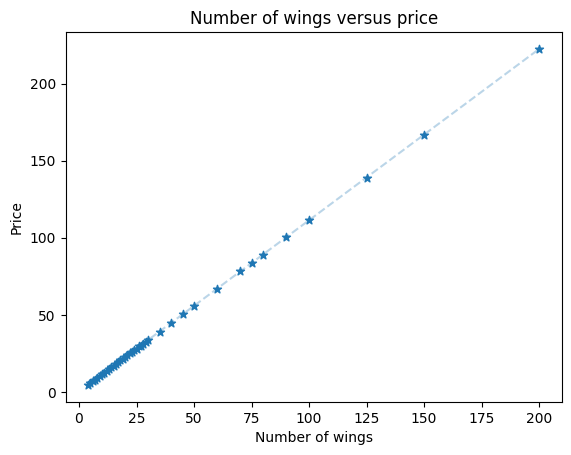

In [5]:
trend_fx = np.polyfit(wing_df.amount, wing_df.price, 1)
trend = np.poly1d(trend_fx)

plt.plot(wing_df.amount, trend(wing_df.amount), alpha=0.3, linestyle="--")
plt.scatter(wing_df.amount, wing_df.price, marker="*")
plt.xlabel("Number of wings")
plt.ylabel("Price")
plt.title("Number of wings versus price")
plt.show()

Now a more interesting analysis is on the number of wings, versus the price per wing. I've added a 3rd degree trend line to describe the shape of the data. 
Regardless, we now can clearly see that this data is all over the place. Why is there a random spike around 25 wing? Why is everything so noisy?

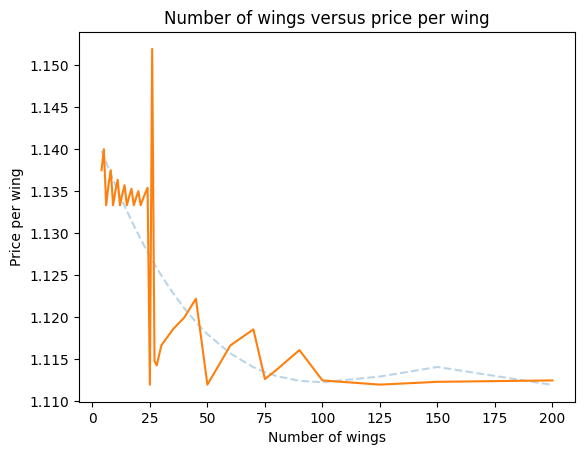

In [6]:
trend_fx = np.polyfit(wing_df.amount, wing_df.price_per_wing, 3)
trend = np.poly1d(trend_fx)

plt.plot(wing_df.amount, trend(wing_df.amount), alpha=0.3, linestyle="--")
plt.plot(wing_df.amount, wing_df.price_per_wing)
plt.xlabel("Number of wings")
plt.ylabel("Price per wing")
plt.title("Number of wings versus price per wing")
plt.show()

Enough with looking at the data, let's now try and formalize/generalize this problem and look at how we could approach it.

## Problem Formulation

On a surface level we're looking to find what the best possible combination of wings is in order to minimize the total cost.
In the below sections we'll think of different ways to solve the problem and discuss the shortcomings.

### Discrete Set Approach
The original way that I approached this problem was to think about a set of tuples each of which consisted of a quantity $q_i$ and a cost $c_i$, and then finding the combination of tuples that resulted in the lowest total cost, while still having the total quantity reach our target number $N$.

$$ 
S = \{ (q_1, c_1), (q_2, c_2), \dots (q_n, c_n) \} \\
\min \sum_{c_i \in S} c_i, \space \forall i \in n(S) \\ 
\text{S.t: } \sum_{q_i \in S} q_i = N, \space \forall i \in n(S)
$$

There a few problems with this formulation, mainly that it doesn't consider buying two sets of wings of the same quantity, but it does lay a nice framework in that it defines the objective and constraint functions of the problem.

### Linear Algebra Approach
Instead of trying to find an optimal set, let's re-frame the questions into finding how many of each individual set we need in-order to accomplish our objective. More well put, if we associate each quantity, price pair with a coefficient $\alpha_i$ then we can re-write the above equations as such:

$$
\min \sum_{i=0}^{n} \alpha_i c_i \\
\text{S.t: } \sum_{i=0}^{n} \alpha_i q_i = N
$$

This is essentially just a linear combination, so we can represent our tuples as vectors instead:
$$
\vec{x_i} = \langle q_i, c_i \rangle
$$

Now we reframe the question as being one where we are trying to find the linear combination of vectors such that the $x$ value equals $N$ and our cost, or $y$ component is as small as possible. The below diagram better illustrates how to interpret the question:

![Vector Graph](WingPriceVectorDiag.png)

We can go one step further and transform our summations into matrix multiplications so that we can define a linear programming problem to optimize, recall the standard form of a linear programming problem.

$$
\min_x \bold{c}^T \bold{x} : \bold{G}\bold{x} \leq \bold{h}, \bold{A}\bold{x} = \bold{b}
$$

In this case we will use the following:

$$
\bold{c}^T = \begin{bmatrix}
c_1 & \dots & c_n \\
\end{bmatrix} \\

\bold{x} = \begin{bmatrix}
\alpha_1 \\
\dots \\
\alpha_n 
\end{bmatrix} \\

\bold{G} = 
\begin{bmatrix}
c_1 & \dots & c_n \\
\end{bmatrix} \\

\bold{h} = c_{max} \\ 

\bold{A} = 
\begin{bmatrix}
q_1 & \dots & q_n \\
\end{bmatrix} \\

\bold{b} = N
$$

So let's quickly implement this using `scipy`:

In [7]:
from scipy.optimize import linprog

In [8]:
def getCostUpper(maxQuant):
    return wing_df[wing_df.amount >= maxQuant].price.iloc[0]

targetQuantity = 19

# Variable we're soling for, ie alpha_i
x = [(0, None) for i in range(0, wing_df.index.size)]

# Price of each wing
c = np.array(wing_df.price)

# Price constraint
G = np.array([[i] for i in wing_df.price]).T
h = [getCostUpper(targetQuantity)]

# Quantity constraint
A = np.array([[i] for i in wing_df.amount]).T
b = [targetQuantity]

results = linprog(c=c, A_ub=G, A_eq=A, b_ub=h, b_eq=b, bounds=x)

In [9]:
results

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: 21.128
              x: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
            nit: 1
          lower:  residual: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
                 marginals: [ 1.020e-01  1.400e-01 ...  5.000e-02
                              1.000e-01]
          upper:  residual: [       inf        inf ...        inf
                                    inf]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: [ 0.000e+00]
                 marginals: [ 1.112e+00]
        ineqlin:  residual: [ 4.220e-01]
                 marginals: [-0.000e+00]
 mip_node_count: 0
 mip_dual_bound: 0.0
        mip_gap: 0.0

In [10]:
results.x

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.76,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [11]:
wing_df[results.x > 0]

,amount,price,price_per_wing
21,25,27.8,1.112


Well this is technically the correct answer, we can't order 0.76 of the 25 wings in real life. Ideally we could additionally constrain the solution to be integers only, but currently `scipy` only implements simplex LP solving, so we're out of luck. So this LP solver will basically just spit out some multiple of 25 wings as the optimal solution since it technically has the best price per wing, even if we can't order it in real life.

### Graph Approach
Ok so looks like linear programming does work, but not quite in our current implementation. However, that graph
![Vector Graph](WingPriceVectorDiag.png)
actually gives us a slightly different way to approach the problem, because it looks like all the linear combinations are starting from some starting location and then ending at some other location, and our job was to find the best path from A to B. In order words, it was basically a graph traversal problem. 

We can set up a graph where the nodes represent the current quantity of wings, and our edges represent the cost to transition from one quantity to another larger quantity. Then finding the best combination just requires finding the cheapest path from $0$ to our target quantity $N$.

![Directed Graph](WingDirectedGraph.png)

The above graph shows what a graph of target value 13 would look like.

Traversing the graph isn't difficult at all, we have a bunch of algorithms to use, like Dijkstra, or Cheapest-first-search, but how we do construct the graph to begin with?

We'll we basically need to find every possible unique combination of quantities that sum to $N$. The combination of sums range anywhere from having a single element, to having many. Even in the above example there are a bunch of ways to sum to 13:

| Possible Combinations| 
| -------------------- |
| 4 + 9 |
| 4 + 4 + 5 |
| 5 + 8 |
| 6 + 7 |
| 13 |

We can compute these combinations using combinations with replacement, ie $C^n_r = \frac{(n + r -1)!}{r!(n-1)!}$, for each length of summation $r$ we want.

In [12]:
import itertools

def getSumCombinations(numbers, target):
    return [
        seq for i in range(len(numbers), 0, -1)
        for seq in itertools.combinations_with_replacement(numbers, i)
        if sum(seq) == target
    ]

target = 17
numbers = wing_df[wing_df.amount <= target].amount
graphPaths = getSumCombinations(numbers, target)

print(graphPaths)

[(4, 4, 4, 5), (4, 4, 9), (4, 5, 8), (4, 6, 7), (5, 5, 7), (5, 6, 6), (4, 13), (5, 12), (6, 11), (7, 10), (8, 9), (17,)]


Now this code is pretty terrible, it's time complexity is $\Theta(2^N)$ where $N$ is the target quantity. Calculating the possible sums for 26 wings, takes more than 15 minutes to do! Yes, there is some optimizations that can be made, but still the construction of the graph is way too high.

Regardless, let's write up some graph visualization and traversal code:

In [13]:
import networkx as nx

def buildGraph(paths, cost, start, end):
    G = nx.DiGraph()
    G.add_node(start)
    G.add_nodes_from(np.unique(np.concatenate([np.cumsum(x) for x in paths])))

    for path_steps in paths:
        prev = start 

        for node in path_steps:
            G.add_edge(prev, prev + node, weight=cost[node])
            prev += node
    return G

edge_weights = dict(zip(wing_df.amount, wing_df.price))
graph = buildGraph(graphPaths, edge_weights, 0, 17)

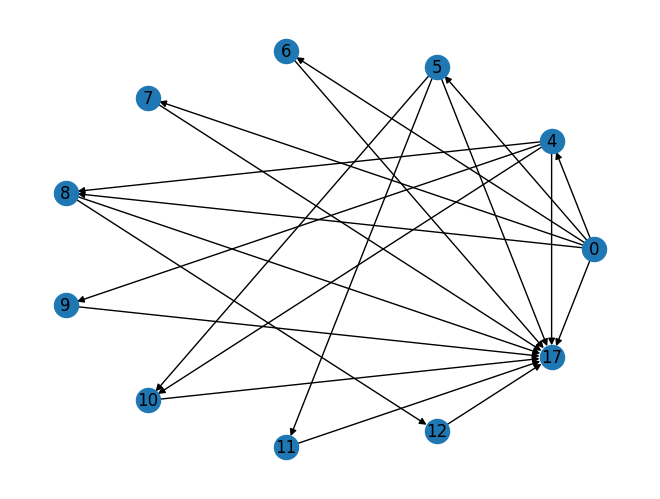

In [14]:
nx.draw(graph, pos=nx.circular_layout(graph), with_labels=True)

In [20]:
def edgeCost(fromNode, toNode, edgeAttr):
    return edgeAttr['weight']

bestSums = [p for p in nx.all_shortest_paths(graph, source=0, target=17, weight=edgeCost)]
print(bestSums)

[[0, 8, 17], [0, 4, 8, 17]]


In [41]:
# np.array(bestSums[0]) 
bestNumWings = [np.array(i)  - np.roll(i, 1) for i in bestSums]
bestNumWings = [i[i > 0] for i in bestNumWings]

print(bestNumWings)

[array([8, 9]), array([4, 4, 9])]


In [48]:
[sum([float(wing_df[wing_df.amount == j].price) for j in i]) for i in bestNumWings]

C:\Users\shays\AppData\Local\Temp\ipykernel_20980\3006648416.py:1: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  [sum([float(wing_df[wing_df.amount == j].price) for j in i]) for i in bestNumWings]


[19.299999999999997, 19.299999999999997]

So from the above it was found that the best way to buy 17 wings is to buy a set of 8, and 9, for a total cost of $19.30.

## Conclusion

This is a pretty dumb problem, but what we found is that there are many ways to approach this optimization problem that all seem vastly different but in the end are connected. 

I think what's interesting about these sorts of problems is that there is math that governs it at the end of the day, and it's only when you delve into it do you start to reveal the underlying problem.